In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [2]:
df = pd.read_csv("../DATA/aus_production.csv")
df["ds"] = pd.to_datetime(df["ds"])
df["index"] = df["ds"]
df = df.set_index("index")
df["y"] = df["Beer"]
df["unique_id"] = "beer"
df = df[["ds", "y", "unique_id"]]
df.head()

,ds,y,unique_id
index,,,
1956-01-01,1956-01-01,284,beer
1956-04-01,1956-04-01,213,beer
1956-07-01,1956-07-01,227,beer
1956-10-01,1956-10-01,308,beer
1957-01-01,1957-01-01,262,beer


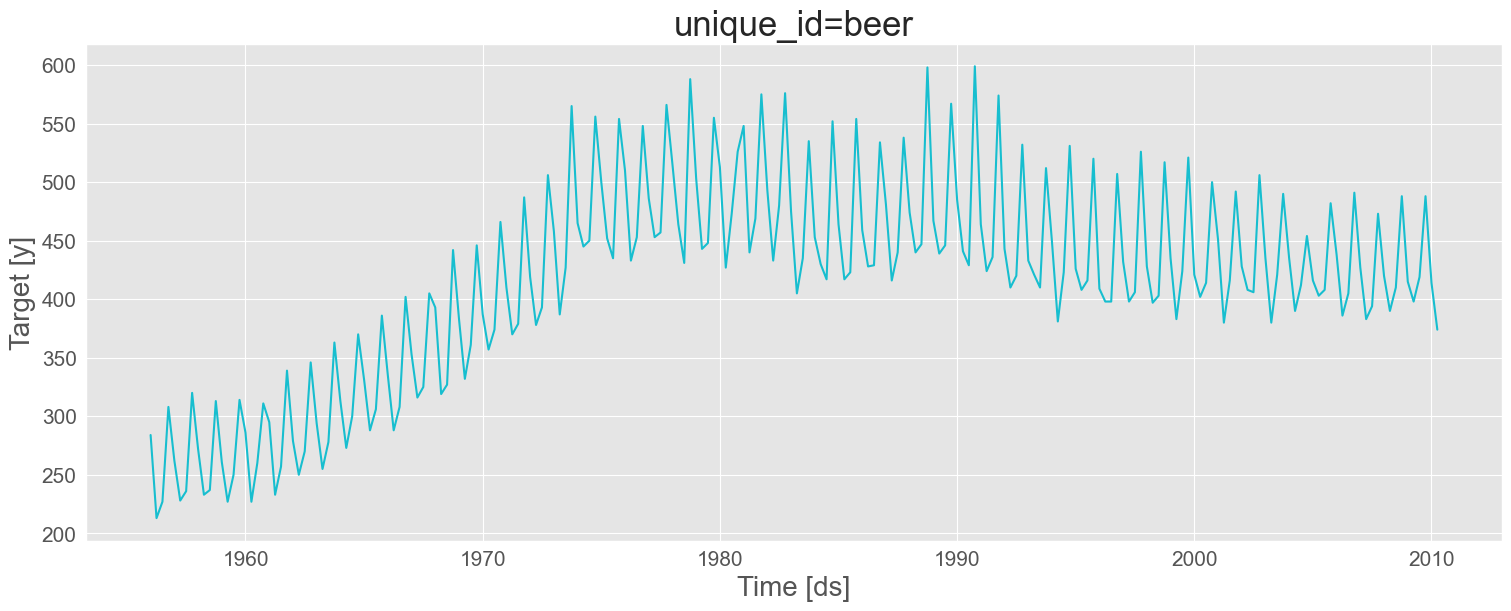

In [3]:
plot_series(df)

<Axes: ylabel='resid'>

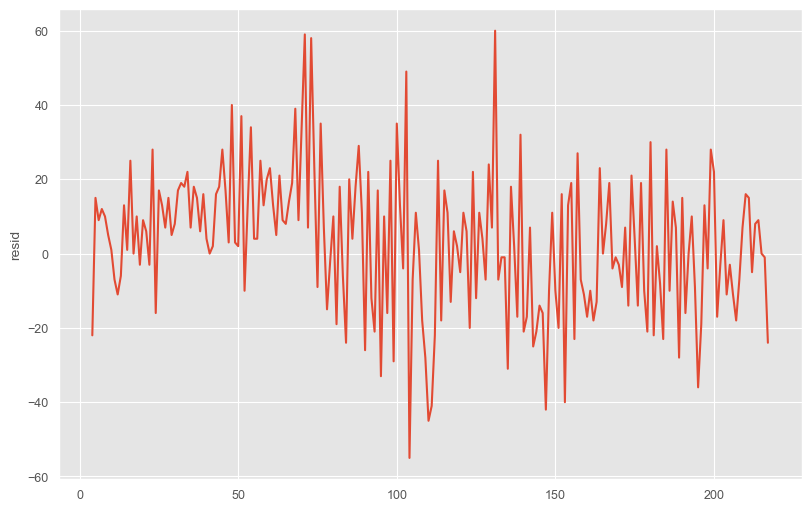

In [9]:
method = SeasonalNaive(season_length=4)
# sns.lineplot(x=df.index, y=df.y)
sf = StatsForecast(models=[method], freq="Q")
sf.fit(df=df)
sf.forecast(h=10, fitted=True, df=df)
insample_preds = sf.forecast_fitted_values()
insample_preds["resid"] = insample_preds["y"] - insample_preds["SeasonalNaive"]
# Look at the residuals
sns.lineplot(insample_preds["resid"])

<Axes: xlabel='index', ylabel='y'>

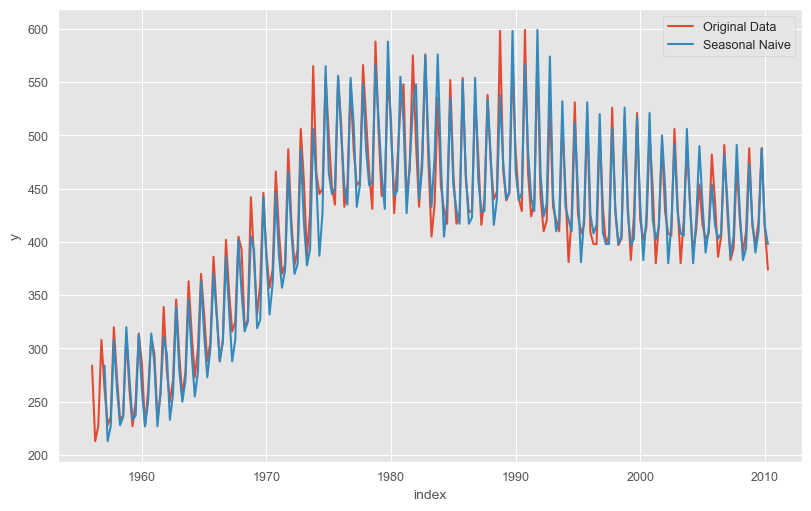

In [10]:
sns.lineplot(x=df.index, y=df.y, label="Original Data")
sns.lineplot(
    x=insample_preds.ds, y=insample_preds.SeasonalNaive, label="Seasonal Naive"
)

<Axes: >

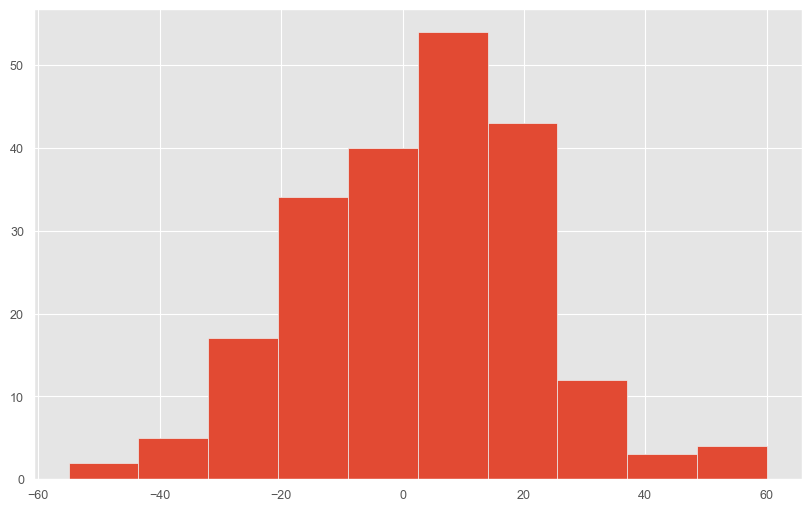

In [11]:
insample_preds.resid.hist()

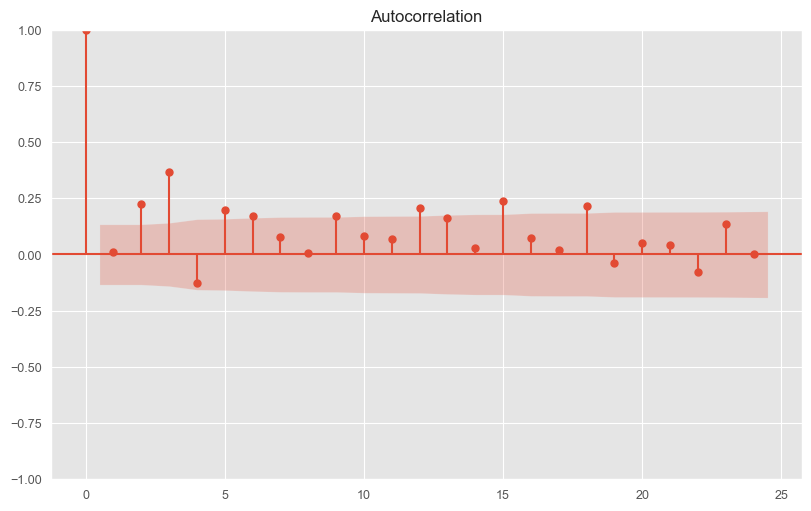

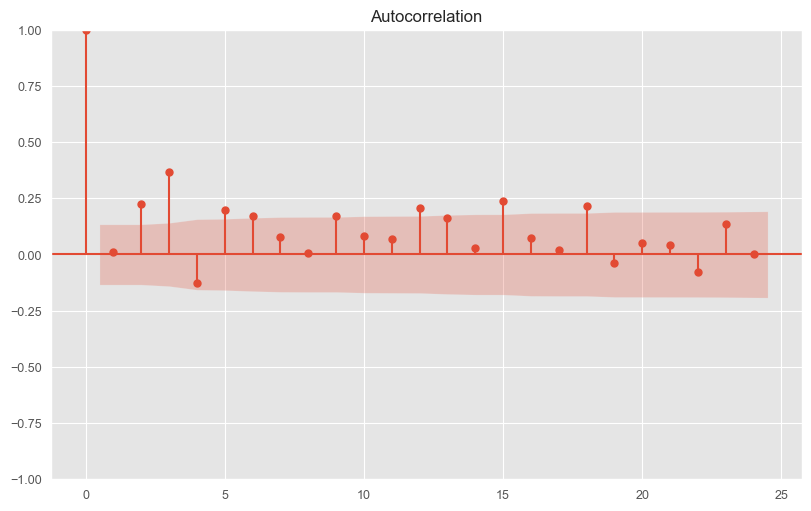

In [12]:
plot_acf(x=insample_preds.resid.dropna())

In [8]:
resid_test = acorr_ljungbox(insample_preds.resid.dropna(), boxpierce=True)
resid_test

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,7.680,5.583e-03,7.574,5.921e-03
2,74.363,7.117e-17,73.027,1.388e-16
3,81.996,1.145e-17,80.485,2.416e-17
4,276.904,1.036e-58,270.004,3.184e-57
5,283.627,3.308e-59,276.510,1.119e-57
6,354.960,1.329e-73,345.213,1.645e-71
7,360.453,7.122e-74,350.478,9.735e-72
8,545.479,1.215e-112,526.978,1.141e-108
9,552.325,3.532e-113,533.477,3.876e-109
10,624.720,8.866e-128,601.868,7.005e-123
